In [12]:
!nvidia-smi

Thu Oct  1 23:09:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0 Off |                  N/A |
| 26%   44C    P8     6W / 151W |     67MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1070    Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   

In [13]:
!ls /kaggle/input/osic-pulmonary-fibrosis-progression

sample_submission.csv  test  test.csv  train  train.csv


In [ ]:
# STEP 1/3 - train ct-chest auto-encoder

In [14]:
import os, sys

import random
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage
from skimage import measure
import SimpleITK as sitk

In [15]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [16]:

root = '/kaggle/input/osic-pulmonary-fibrosis-progression'

train_csv = os.path.join(root,'train.csv')
train_folder = os.path.join(root,'train')

test_csv = os.path.join(root,'test.csv')
test_folder = os.path.join(root,'test')

In [198]:
# https://gist.github.com/pangyuteng/7f54dbfcd67fb9d43a85f8c6818fca7b

import os
import SimpleITK as sitk
import pydicom
import traceback
from scipy import ndimage

def get_slice_location(dcm_file):
    ds = pydicom.dcmread(dcm_file)
    try:
        val = float(ds.SliceLocation)
    except:
        val = float('nan')
        
    return dcm_file, val

def imread(fpath):
    if os.path.isdir(fpath):
        
        file_list = os.listdir(fpath)
        file_loc_list = sorted([get_slice_location(os.path.join(fpath,x)) for x in file_list],key=lambda x:x[1])    
        dicom_names = [x[0] for x in file_loc_list]
        
        dcm = pydicom.dcmread(dicom_names[-1])
        # convert to HU
        b = dcm.RescaleIntercept
        m = dcm.RescaleSlope
        force_rescale = False
        if (b,m) != (-1024, 1):
            force_rescale = True
            print(f'force_rescale intercept {b} slope {m}',fpath)
            
        try:
            reader = sitk.ImageSeriesReader()
            reader.SetFileNames(dicom_names)
            img = reader.Execute()
        except:
            traceback.print_exc()
            org_dicom_names = [x[0] for x in file_loc_list]
            dicom_names = []
            for x in org_dicom_names:
                try:
                    ds = pydicom.dcmread(x)
                    _=ds.pixel_array
                    dicom_names.append(x)
                except:
                    #traceback.print_exc()
                    pass
            reader = sitk.ImageSeriesReader()
            reader.SetFileNames(dicom_names)
            img = reader.Execute()
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
        img = reader.Execute()
        
        
    arr = sitk.GetArrayFromImage(img)
    if force_rescale:
        # arr = m*arr+b not working. itk should be doing this already.
        pass
        def crop_center(img,cropx,cropy):
            c,x,y = img.shape
            startx = x//2 - cropx//2
            starty = y//2 - cropy//2    
            return img[:, startx:startx+cropx, starty:starty+cropy]    
        tmp = crop_center(arr,128,128)
        #bad:[-3005. -1756.], oky:[-886.  234.]
        lims = np.percentile(tmp,[5,95])
        arr = (arr-lims[0])/(lims[1]-lims[0])
        arr = (arr*1100)-900
        
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()    
    return arr,spacing,origin,direction

def imwrite(fpath,arr,spacing,origin,direction,use_compression=True):
    img = sitk.GetImageFromArray(arr)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    img.SetDirection(direction)
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img)
    
def _read_img(kind,patient_id):
    if kind == 'train':
        folder = train_folder
    else:
        folder = test_folder
    fpath = os.path.join(folder,patient_id)
    arr,spacing,origin,direction = imread(fpath)
    arr = arr.astype(np.int16)
    return arr,spacing,origin,direction


# naive lung with old school image processing technique!
def get_lung_mask(arr):
    
    bkgd = np.zeros(arr.shape).astype(np.uint8)
    bkgd[:,:,:2]=1
    bkgd[:,:,-2:]=1
    bkgd[:,:2,:]=1
    bkgd[:,-2:,:]=1
    
    # assume < 0 HU are voxels within lung
    procarr = (arr < -300).astype(np.int)
    procarr = ndimage.morphology.binary_closing(procarr,iterations=1)

    label_image, num = ndimage.label(procarr)
    region = measure.regionprops(label_image)

    region = sorted(region,key=lambda x:x.area,reverse=True)
    lung_mask = np.zeros(arr.shape).astype(np.uint8)
    
    # assume `x` largest air pockets except covering bkgd is lung, increase x for lung with fibrosis (?)
    x=3
    for r in region[:x]: # should just be 1 or 2, but getting x, since closing may not work.
        mask = label_image==r.label
        contain_bkgd = np.sum(mask*bkgd) > 0
        if contain_bkgd > 0:
            continue
        lung_mask[mask==1]=1
    
    lung_mask = ndimage.morphology.binary_dilation(lung_mask,iterations=1)
    
    return lung_mask



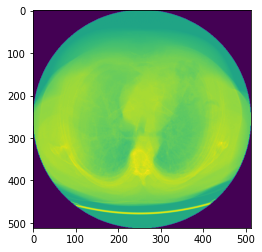

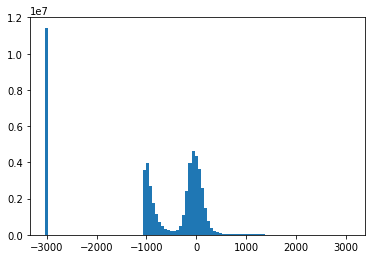

In [199]:
kind, patient_id = 'train','ID00032637202181710233084'
arr,spacing,origin,direction = _read_img(kind,patient_id)
plt.figure(0)
plt.imshow(np.mean(arr,axis=0))
plt.figure(1)
_ = plt.hist(arr.ravel(),bins=100)

force_rescale intercept 0 slope 1.000000 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00132637202222178761324


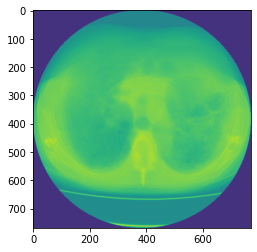

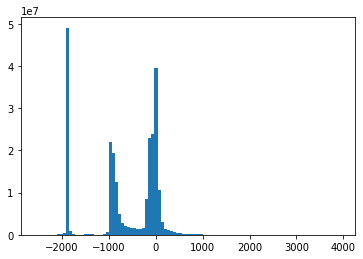

In [200]:
kind, patient_id = 'train','ID00132637202222178761324' # problematic case, image size 768x768, intercept slope is invalid
arr,spacing,origin,direction = _read_img(kind,patient_id)
plt.figure(0)
plt.imshow(np.mean(arr,axis=0))
plt.figure(1)
_ = plt.hist(arr.ravel(),bins=100)

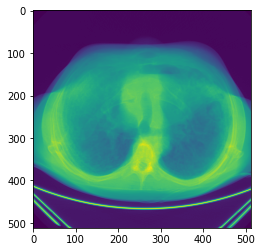

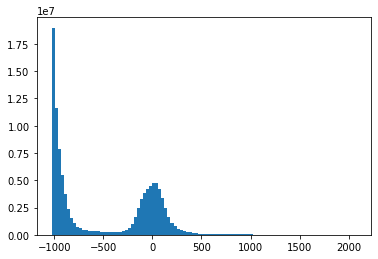

In [220]:
kind, patient_id = 'train','ID00426637202313170790466' 
arr,spacing,origin,direction = _read_img(kind,patient_id)
plt.figure(0)
plt.imshow(np.mean(arr,axis=0))
plt.figure(1)
_ = plt.hist(arr.ravel(),bins=100)

segment_list len: 120


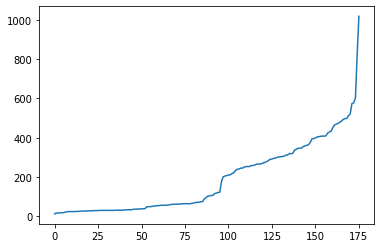

In [18]:
# get image count
count_dict = {}
for x in os.listdir(train_folder):
    count = len(os.listdir(os.path.join(train_folder,x)))
    count_dict[x]=count
plt.plot(sorted(count_dict.values()))


segment_list = [k for k,v in count_dict.items() if 40<v<600]
print('segment_list len:',len(segment_list))
# arbitrary grab 120 series based on image count.

8213940 77594624 0.10585707587164801
9001236 95420416 0.09433239108913548
1906410 15728640 0.12120628356933594
8408026 66322432 0.1267749952233356
2073951 12845056 0.16145908589265784
8101822 79167488 0.10233774248337904


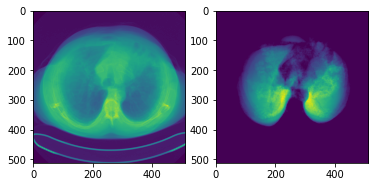

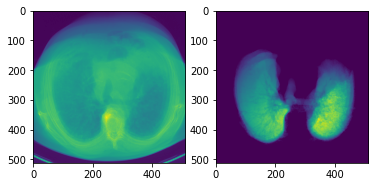

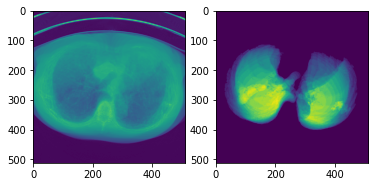

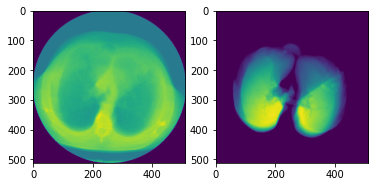

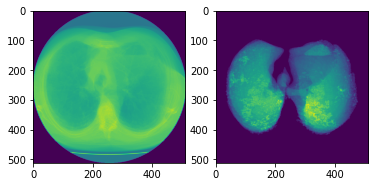

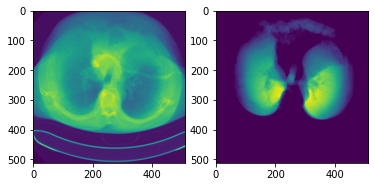

In [19]:
kind = 'train'
# check lung seg.
kwargs = {'aspect':1}
c=0
for n,patient in enumerate(segment_list):
    img,spacing,origin,direction = _read_img(kind,patient)
    mask = get_lung_mask(img)
    
    lung_voxel_count = np.sum(mask)
    total_voxel_count = np.prod(mask.shape)
    print(lung_voxel_count,total_voxel_count,lung_voxel_count/total_voxel_count)
    plt.figure(c)
    plt.subplot(121)
    plt.imshow(np.sum(img,axis=0),**kwargs)
    plt.subplot(122)
    plt.imshow(np.sum(mask,axis=0),**kwargs)
    
    c+=1
    if c > 5:
        break
        

In [20]:
img_root = 'image'
mask_root = 'mask'
cache_root = 'cache'
static_root = 'static'

raw_img_root = 'raw/img'
raw_mask_root = 'raw/mask'

os.makedirs(img_root,exist_ok=True)
os.makedirs(mask_root,exist_ok=True)
os.makedirs(static_root,exist_ok=True)
os.makedirs(cache_root,exist_ok=True)

os.makedirs(raw_img_root,exist_ok=True)
os.makedirs(raw_mask_root,exist_ok=True)

In [21]:
import json
from tqdm.notebook import tqdm

# perform lung seg.

if os.path.exists('lung_list.json'):
    with open('lung_list.json','r') as f:
        mydict = json.loads(f.read())
        lung_list = mydict['passed']
        failed_patient_list = mydict['failed']
else:
    failed_patient_list = []
    lung_list = []

kind = 'train'
for patient in tqdm(segment_list):
    
    img_path = os.path.join(img_root,f'{patient}.nii.gz')
    lung_mask_path = os.path.join(mask_root,f'{patient}.nii.gz')
    
    if os.path.exists(lung_mask_path) and os.path.exists(img_path):
        item = {
            'uid':patient,
            'img_path':img_path,
            'lung_mask_path':lung_mask_path
        }
        if item not in lung_list:
            lung_list.append(item)
        continue

    if patient in failed_patient_list:
        continue
    
    img,spacing,origin,direction = _read_img(kind,patient)
    mask = get_lung_mask(img)
    
    if img.shape[1] != 512 or img.shape[2] != 512:
        failed_patient_list.append(patient)
        continue
        
    lung_voxel_count = np.sum(mask)
    total_voxel_count = np.prod(mask.shape)
    lung_ratio = lung_voxel_count/total_voxel_count
    
    # qc. if lung mask too small, likely lung seg failed
    if lung_ratio < 0.05:
        failed_patient_list.append(patient)
        continue
        
    mask = mask.astype(np.uint8)
    imwrite(lung_mask_path,mask,spacing,origin,direction)    
    imwrite(img_path,img,spacing,origin,direction)
    
    lung_list.append({
        'uid':patient,
        'img_path':img_path,
        'lung_mask_path':lung_mask_path
    })
    
with open('lung_list.json','w') as f:
    mydict = {'passed':lung_list,'failed':failed_patient_list}
    f.write(json.dumps(mydict))

In [22]:
len(lung_list)

81

In [23]:
png_path_list = []
for item in tqdm(lung_list):
    patient = item['uid']
    img_path = item['img_path']
    lung_mask_path = item['lung_mask_path']
    png_path = os.path.join(cache_root,f'{patient}_mask_review.png')
    
    if item in failed_patient_list:
        continue
        
    if os.path.exists(png_path):
        png_path_list.append(png_path)
        continue
        
    img,spacing,origin,direction = imread(img_path)
    mask,spacing,origin,direction = imread(lung_mask_path)
    plt.subplot(121)
    plt.imshow(np.mean(img,axis=1),cmap='gray')
    plt.subplot(122)
    plt.imshow(np.mean(mask,axis=1),cmap='gray')
    plt.savefig(png_path)
    plt.close()
    png_path_list.append(png_path)

In [24]:
from IPython.core.display import display, HTML
htmltext = ''
for item in png_path_list:
    htmltext+=f"""{item}:<img src='{item}'> <br>"""
display(HTML(htmltext))
#print(htmltext)

In [25]:
visually_failed = [
    'ID00411637202309374271828',
    'ID00381637202299644114027',
    'ID00323637202285211956970',
]
failed_patient_list.append(visually_failed)

In [26]:

# for sake of simplicity save as individual slices

if os.path.exists('raw_list.json'):
    with open('raw_list.json','r') as f:
        raw_list = json.loads(f.read())
else:
    raw_list = []

for item in tqdm(lung_list):
    uid = item['uid']
    
    axial_img_path = os.path.join(raw_img_root,f'img_{uid}_0.npy')
    axial_mask_path = os.path.join(raw_mask_root,f'mask_{uid}_0.npy')

    tmp=dict(
        img=axial_img_path,
        mask=axial_mask_path,
    )
    if tmp in raw_list:
        continue

    if uid in failed_patient_list:
        continue
    
    img,spacing,origin,direction = imread(item['img_path'])
    mask,spacing,origin,direction = imread(item['lung_mask_path'])
    
    if img.shape[1] != 512 or img.shape[2] != 512:
        continue
    
    for x in range(img.shape[0]):
        try:
            axial_img_path = os.path.join(raw_img_root,f'img_{uid}_{x}.npy')
            axial_mask_path = os.path.join(raw_mask_root,f'mask_{uid}_{x}.npy')
            axial_img = img[x,:,:].squeeze().astype(np.int16)
            axial_mask = mask[x,:,:].squeeze().astype(np.uint8)
            np.save(axial_img_path,axial_img)
            np.save(axial_mask_path,axial_mask)
            
            raw_list.append(dict(
                img=axial_img_path,
                mask=axial_mask_path,
            ))
        except:
            pass
        
with open('raw_list.json','w') as f:
    f.write(json.dumps(raw_list))

In [27]:
! ls raw/img | wc -l
! ls raw/mask | wc -l

18423
18423


In [28]:
len(raw_list)

18423

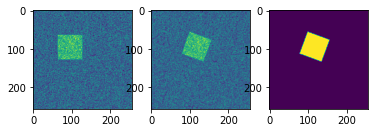

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import albumentations as A

image = np.random.rand(256,256)
image[64:128,64:128]+=0.5
mask = np.zeros((256,256))
mask[64:128,64:128]=1

plt.subplot(131)
plt.imshow(image)

aug_pipeline = A.Compose([
    A.ShiftScaleRotate(p=0.5),    
])

augmented = aug_pipeline(
    image=image,
    mask=mask,
)

plt.subplot(132)
plt.imshow(augmented['image'])
plt.subplot(133)
plt.imshow(augmented['mask'])

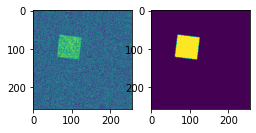

In [30]:

augmented = aug_pipeline(
    image=image,
    mask=mask,
)

plt.subplot(132)
plt.imshow(augmented['image'])
plt.subplot(133)
plt.imshow(augmented['mask'])

In [31]:

#https://gist.github.com/pangyuteng/fdbf0e13cd9173dc11aabccb30f8a2ad

import pandas as pd
import numpy as np
import albumentations as A

aug_pipeline = A.Compose([
    A.ShiftScaleRotate(p=0.5),    
])

def readimage(image_file,mask_file,augment):

    _x_sample = np.load(image_file).astype(np.float)
    x_sample = np.copy(_x_sample)
    
    y_mask = np.load(mask_file)
    y_mask = y_mask.astype(np.float)
    
    minval,maxval = -1000,1000
    x_sample = (x_sample-minval)/(maxval-minval)
    x_sample = x_sample.clip(0,1)
        
    # initialize zero mean noise
    minval,maxval = -1000,-400
    y_sample = (_x_sample-minval)/(maxval-minval)
    y_sample = y_sample.clip(0,1)
    
    y_sample[y_mask==0] = 0
    
    y_sample = np.expand_dims(y_sample,axis=-1)
    y_mask = np.expand_dims(y_mask,axis=-1)
    y_sample = np.concatenate([y_sample,y_mask],axis=-1)
    
    augmented = aug_pipeline(
        image=x_sample,
        mask=y_sample,
    )
    x_sample = augmented['image']
    y_sample = augmented['mask']
    
    x_sample = np.expand_dims(x_sample,axis=-1)
    
    return x_sample, y_sample

# https://github.com/keras-team/keras/issues/9707

from tensorflow.keras.utils import Sequence
class MyDataGenerator(Sequence):
    def __init__(self,data_list,batch_size=8,shuffle=True,augment=False):
        self.y = np.array([x['mask'] for x in data_list])
        self.x = np.array([x['img'] for x in data_list])
        
        self.indices = np.arange(len(self.y))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        
    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        if self.shuffle:
            inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_x = self.x[inds]
            batch_y = self.y[inds]
        else:
            batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
            
        # read your data here using the batch lists, batch_x and batch_y
        x = []
        y = []
        for image_file,mask_file, in zip(batch_x,batch_y):
            ix,iy=readimage(image_file,mask_file,self.augment)
            x.append(ix)
            y.append(iy)

        x,y = np.asarray(x, dtype=np.float), np.asarray(y, dtype=np.float)
        #print(type(x),type(y),x.shape,y.shape)
        return x,y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [32]:
len(raw_list)

18423

(15, 512, 512, 1) (15, 512, 512, 2)
1.0 0.0
1.0 0.0


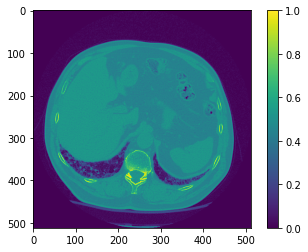

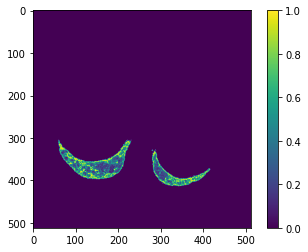

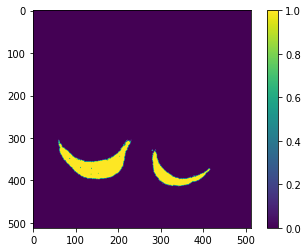

In [33]:
batch_size = 15
dg = MyDataGenerator(raw_list,batch_size=batch_size)

len(raw_list)/batch_size
x,y = dg[50]
print(x.shape,y.shape)

ind = 10
plt.figure(0)
plt.imshow(x[ind,:])
plt.colorbar()
plt.figure(1)
plt.imshow(y[ind,:,:,0])
plt.colorbar()
plt.figure(2)
plt.imshow(y[ind,:,:,1])
plt.colorbar()

print(np.max(x[ind,:]),np.min(x[ind,:]))
print(np.max(y[ind,:]),np.min(y[ind,:]))

In [34]:

# https://keras.io/examples/vision/oxford_pets_image_segmentation/

from tensorflow import keras
from tensorflow.keras import layers


def get_lung_feat_model():
    
    img_size = (512,512)
    num_classes = 1
    
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual
    
    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x) # <--- ... 
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
            
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    mid = x
    for filters in [256, 128, 64, 32]:
        
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    
    # Add a per-pixel classification layer
    intensity = layers.Conv2D(num_classes, 3, activation="linear", padding="same")(x)
    mask = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    outputs = layers.Concatenate(axis=-1)([intensity,mask])
    
    #
    #************************************************* ^^^^^^^^^^^ ************************************************* 
    #                                            linear/sigmoid 
    
    # Define the model
    model = keras.Model(inputs, outputs)
    model_alt = keras.Model(inputs, [outputs,mid])
    return model, model_alt

keras.backend.clear_session()
# Build model
model, model_alt = get_lung_feat_model()
model.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [35]:
from sklearn.model_selection import train_test_split
X_tt, X_test, y_tt, y_test = train_test_split(raw_list,raw_list,test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tt,y_tt,test_size=0.25, random_state=42)

print('6:2:2')
print(len(X_train))
print(len(X_val))
print(len(X_test))

6:2:2
11053
3685
3685


In [54]:
import tensorflow as tf

batch_size = 8
epochs = 50

keras.backend.clear_session()
# Build model
model, model_alt = get_lung_feat_model()
#model.summary()

def mse_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
    
def bc_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))

def mloss(_lambda):
    def loss(y_true, y_pred):
        return \
            _lambda * mse_loss(y_true[:,:,:,0], y_pred[:,:,:,0]) + \
            (1 - _lambda)*bc_loss(y_true[:,:,:,1], y_pred[:,:,:,1])
    return loss



opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=mloss(0.8))

callbacks = [
    keras.callbacks.ModelCheckpoint("lung_feat.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
train_gen = MyDataGenerator(X_train,batch_size=batch_size)
val_gen = MyDataGenerator(X_val)
history = model.fit(train_gen,epochs=epochs, validation_data=val_gen, callbacks=callbacks)

model_alt.save_weights('latent.h5')

Epoch 1/50
1381/1381 [==============================] - 824s 597ms/step - loss: 0.5937 - val_loss: 0.0304
Epoch 2/50
1381/1381 [==============================] - 822s 595ms/step - loss: 0.0274 - val_loss: 0.0331
Epoch 3/50
1381/1381 [==============================] - 821s 595ms/step - loss: 0.0213 - val_loss: 0.0187
Epoch 4/50
1381/1381 [==============================] - 819s 593ms/step - loss: 0.0188 - val_loss: 0.0179
Epoch 5/50
1381/1381 [==============================] - 818s 592ms/step - loss: 0.0169 - val_loss: 0.0156
Epoch 6/50
1381/1381 [==============================] - 817s 591ms/step - loss: 0.0155 - val_loss: 0.0145
Epoch 7/50
1381/1381 [==============================] - 815s 590ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 8/50
1381/1381 [==============================] - 813s 589ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 9/50
1381/1381 [==============================] - 812s 588ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 10/50
1381/1381 [=======================

<AxesSubplot:>

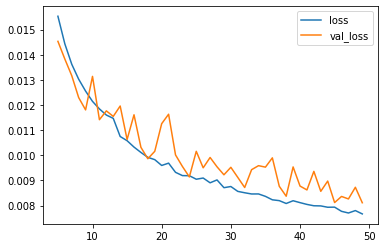

In [55]:
lossdf = pd.DataFrame(history.history)
lossdf[['loss','val_loss']].loc[5:].pllot()

In [56]:
test_gen = MyDataGenerator(X_test)
model.load_weights('lung_feat.h5')
model.evaluate(test_gen)

460/460 [==============================] - 97s 211ms/step - loss: 0.0077


0.0077471621334552765

(8, 512, 512, 2)


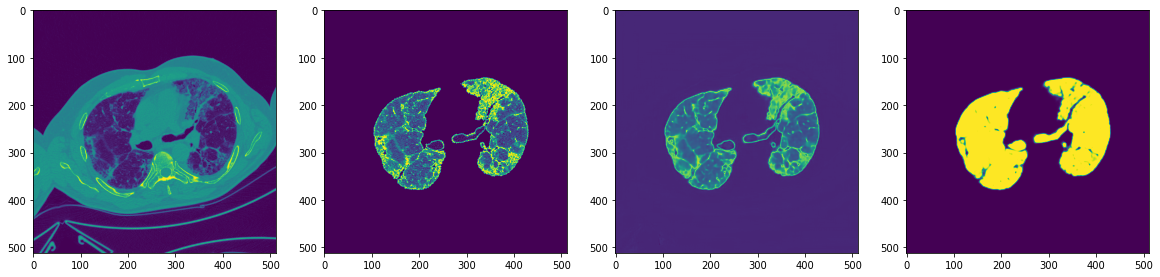

In [57]:
ind1 = 0
item_img,mask_img = test_gen[7]
out = model.predict(item_img)
print(out.shape)
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(item_img[ind1,:,:])
plt.subplot(142)
plt.imshow(mask_img[ind1,:,:,0])
plt.subplot(143)
plt.imshow(out[ind1,:,:,0].squeeze())
plt.subplot(144)
plt.imshow(out[ind1,:,:,1].squeeze())

In [58]:
model_alt.load_weights('latent.h5')

In [59]:
item_img,mask_img = test_gen[7]
out,latent = model_alt.predict(item_img)

(8, 32, 32, 256)


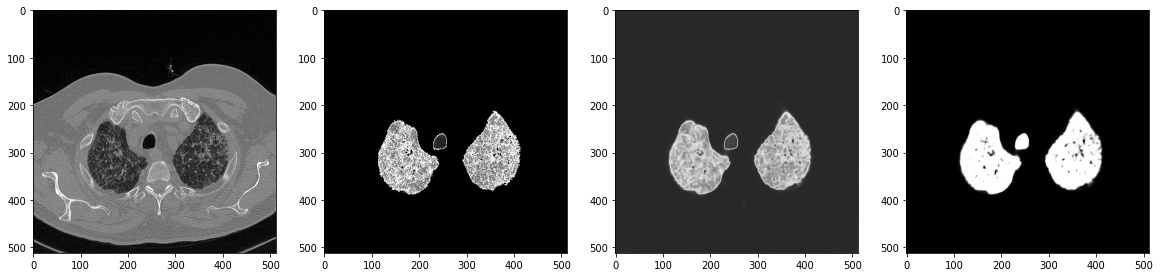

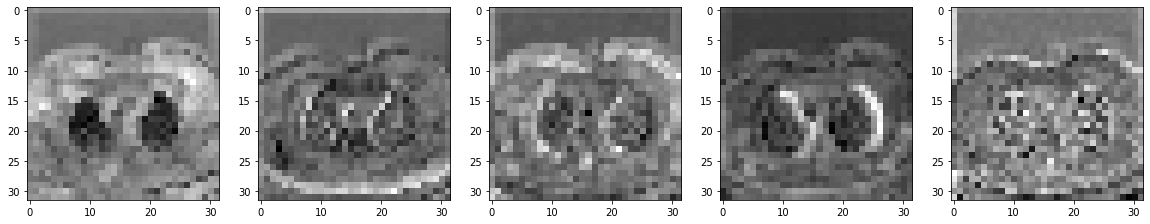

In [60]:
ind1 = 7
kwargs = {'cmap':'gray'}
print(latent.shape)
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(item_img[ind1,:,:],**kwargs)
plt.subplot(142)
plt.imshow(mask_img[ind1,:,:,0],**kwargs)
plt.subplot(143)
plt.imshow(out[ind1,:,:,0].squeeze(),**kwargs)
plt.subplot(144)
plt.imshow(out[ind1,:,:,1].squeeze(),**kwargs)

plt.figure(figsize=(20,20))
plt.subplot(151)
plt.imshow(latent[ind1,:,:,0].squeeze(),**kwargs)
plt.subplot(152)
plt.imshow(latent[ind1,:,:,1].squeeze(),**kwargs)
plt.subplot(153)
plt.imshow(latent[ind1,:,:,2].squeeze(),**kwargs)
plt.subplot(154)
plt.imshow(latent[ind1,:,:,3].squeeze(),**kwargs)
plt.subplot(155)
plt.imshow(latent[ind1,:,:,4].squeeze(),**kwargs)


(8, 32, 32, 256)


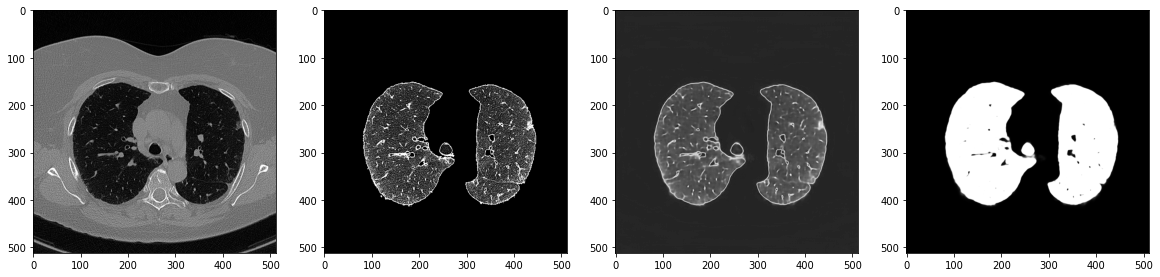

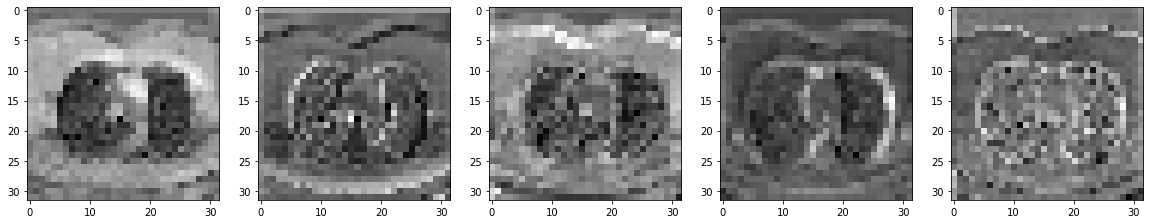

In [61]:
ind1 = 5
kwargs = {'cmap':'gray'}
print(latent.shape)
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(item_img[ind1,:,:],**kwargs)
plt.subplot(142)
plt.imshow(mask_img[ind1,:,:,0],**kwargs)
plt.subplot(143)
plt.imshow(out[ind1,:,:,0].squeeze(),**kwargs)
plt.subplot(144)
plt.imshow(out[ind1,:,:,1].squeeze(),**kwargs)

plt.figure(figsize=(20,20))
plt.subplot(151)
plt.imshow(latent[ind1,:,:,0].squeeze(),**kwargs)
plt.subplot(152)
plt.imshow(latent[ind1,:,:,1].squeeze(),**kwargs)
plt.subplot(153)
plt.imshow(latent[ind1,:,:,2].squeeze(),**kwargs)
plt.subplot(154)
plt.imshow(latent[ind1,:,:,3].squeeze(),**kwargs)
plt.subplot(155)
plt.imshow(latent[ind1,:,:,4].squeeze(),**kwargs)


In [ ]:
#STEP 2/3 - create csv patient-ct-scan

In [36]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

from tqdm import tqdm
from PIL import Image
import pydicom

In [37]:
keras.backend.clear_session()

# Build model
_, model = get_lung_feat_model()
model.load_weights('latent.h5')
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

done


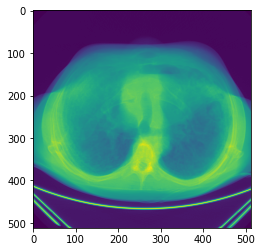

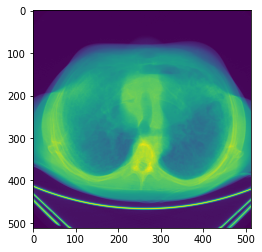

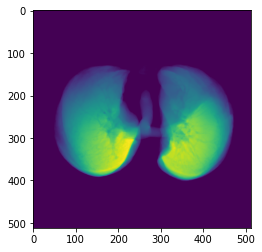

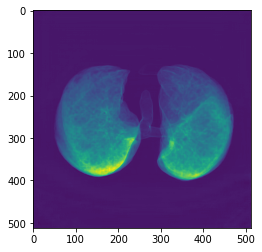

In [266]:
from scipy import ndimage,stats
from skimage import measure

def get_feat(kind,patient_id,sample_size=100,plot=False):
    
    arr,spacing,origin,direction = _read_img(kind,patient_id)
    
    if plot:
        plt.figure(0)
        plt.imshow(np.mean(arr.squeeze(),axis=0))

    '''
    def crop_center(img,cropx,cropy):
        c,x,y = img.shape
        startx = x//2 - cropx//2
        starty = y//2 - cropy//2    
        return img[:, startx:startx+cropx, starty:starty+cropy]
    
    arr = crop_center(arr,512,512) # TODO: thou shall not be lazy
    '''
    
    target_shape = np.array([arr.shape[0],512,512])    
    shrink = (target_shape/np.array(arr.shape))[1:]
    
    ## ndzoom is too memory intensive
    #arr = ndimage.zoom(arr,shrink,order=0, mode='constant')
    
    if arr.shape[1] != 512:
        newarr = np.zeros([arr.shape[0],512,512]).astype(np.int32)
        for x in range(arr.shape[0]):
            newarr[x,:,:] = ndimage.zoom(arr[x,:,:],shrink,order=0, mode='constant')
        arr = newarr
        
    #print(arr.shape,'@@@@')
    arr = np.expand_dims(arr,-1)
    def mynorm(x):
        x = (x+1000)/2000
        x = x.clip(0,1)
        return x
    
    arr = mynorm(arr)
    
    # "digital biopsy" ...
    predraw, latent = model.predict(arr,batch_size=4)
    
    pred = predraw[:,:,:,1].squeeze() # 1 is lung mask, 0 is intensity
    label_image, num = ndimage.label(pred > 0.2) # arb th
    region = measure.regionprops(label_image) 
    region = sorted(region,key=lambda x:x.area,reverse=True)
    mask = np.zeros(pred.shape).astype(np.uint8)
    for n,x in enumerate(region):
        mask[label_image == x.label]=1
        if n > 2:
            break
    
    if plot:
        plt.figure(1)
        plt.imshow(np.mean(arr.squeeze(),axis=0))
        plt.figure(2)
        plt.imshow(np.mean(predraw[:,:,:,1].squeeze(),axis=0))
        plt.figure(3)
        plt.imshow(np.mean(predraw[:,:,:,0].squeeze(),axis=0))
        
    mask = np.expand_dims(mask,axis=-1)
    
    # compute kurtosis, skewness
    lung_ind = np.where(mask==1)

    if lung_ind[0].shape[0]== 0:
        print('here...',patient_id)
        lung_ind = np.where(mask>=0)
    
    lung_intensities = arr[lung_ind]
    
    myfeat = {}

    myskew = stats.skew(lung_intensities,axis=0)
    myfeat['skew_val']=myskew

    mykurt = stats.kurtosis(lung_intensities,axis=0)
    myfeat['kurt_val']=mykurt

    for th in np.arange(0,-500,-100):
        feat_name = f'ra_gt_{th}'
        th = mynorm(th)
        val = np.sum(lung_intensities>th)/len(lung_intensities)
        myfeat[feat_name]=val

    for th in np.arange(-750,-1150,-100):
        feat_name = f'ra_lt_{th}'
        th = mynorm(th)
        val = np.sum(lung_intensities<th)/len(lung_intensities)
        myfeat[feat_name]=val

    # obtain output from encoder as features    
    smask = ndimage.zoom(mask,(1,0.0625,0.0625,1))
    smask_shape = smask.shape
    latent = np.reshape(latent,(np.prod(smask_shape),256))
    smask = np.reshape(smask,(np.prod(smask_shape),1)).squeeze()
    
    lung_ind = np.where(smask==1)[0]
    lung_feat = latent[lung_ind,:]
    
    if lung_feat.shape[0]== 0:
        lung_feat = latent
    
    mymean = np.nanmean(lung_feat,axis=0)
    mystd = np.nanstd(lung_feat,axis=0)
    mykurt = stats.kurtosis(lung_feat,axis=0)
    myskew = stats.skew(lung_feat,axis=0)
    
    latent_vec = np.concatenate([mymean,mystd,mykurt,myskew])
    for n,x in enumerate(latent_vec):
        myfeat[f'latent_{n}']=x
        
    return myfeat

kind, patient_id = 'train','ID00032637202181710233084'
kind, patient_id = 'train','ID00132637202222178761324' # problematic case, image size 768x768
kind, patient_id = 'train','ID00426637202313170790466'
sampled_feat = get_feat(kind,patient_id,plot=True)
print('done')

In [274]:
sampled_feat

{'skew_val': 1.3609110665687352,
 'kurt_val': 1.4388595955024304,
 'ra_gt_0': 0.03040118055732743,
 'ra_gt_-100': 0.06042741926554404,
 'ra_gt_-200': 0.09064437844783221,
 'ra_gt_-300': 0.12317790537408092,
 'ra_gt_-400': 0.16309930318425364,
 'ra_lt_-750': 0.571955617412001,
 'ra_lt_-850': 0.3506972409960599,
 'ra_lt_-950': 0.0701261611523015,
 'ra_lt_-1050': 0.0,
 'latent_0': -1.2962979,
 'latent_1': -0.6086763,
 'latent_2': -0.45022893,
 'latent_3': -0.5501745,
 'latent_4': 0.00010962137,
 'latent_5': 0.090063475,
 'latent_6': -0.33178967,
 'latent_7': -0.315834,
 'latent_8': -0.2611264,
 'latent_9': 0.53861415,
 'latent_10': 0.39967227,
 'latent_11': -0.044385843,
 'latent_12': -0.03559958,
 'latent_13': -0.95434886,
 'latent_14': 0.31319186,
 'latent_15': 0.32870907,
 'latent_16': -0.1394836,
 'latent_17': -0.070378274,
 'latent_18': 0.15742384,
 'latent_19': -0.13144809,
 'latent_20': -0.45179334,
 'latent_21': -0.2742409,
 'latent_22': 0.31012338,
 'latent_23': 1.0486854,
 'late

In [268]:
# todo.
# cluster the patients to x  groups. - with kemeans.
# kurtosis vs prct fvc (closest timepoint)
# patient, csv per patient.

In [385]:
root = '/kaggle/input/osic-pulmonary-fibrosis-progression'

train_csv = os.path.join(root,'train.csv')
train_folder = os.path.join(root,'train')

test_csv = os.path.join(root,'test.csv')
test_folder = os.path.join(root,'test')

In [386]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

In [387]:
ROOT = "/kaggle/input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE = 128

In [388]:
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

sub = pd.read_csv(f"{ROOT}/sample_submission.csv")

sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))

sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

In [389]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'

data = tr.append([chunk, sub])

In [390]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_129
726,ID00426637202313170790466,130,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_130
727,ID00426637202313170790466,131,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_131
728,ID00426637202313170790466,132,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_132


In [359]:
!ls working/feat | wc -l

176


In [391]:
ROOT = "/kaggle/input/osic-pulmonary-fibrosis-progression"
test_subj_list = os.listdir(os.path.join(ROOT,'test'))
train_subj_list = os.listdir(os.path.join(ROOT,'train'))

feat_root = 'working/feat'
os.makedirs(feat_root,exist_ok=True)

import ast

for patient_id in tqdm(sorted(list(set(data.Patient.values)))):
    feat_file = os.path.join(feat_root,f'{patient_id}.csv')
    if os.path.exists(feat_file):
        #print(patient_id,'skip')
        continue
    #print(patient_id)
    if patient_id in test_subj_list:
        kind = 'test'
    elif patient_id in train_subj_list:
        kind = 'train'
    else:
        continue
    
    sampled_feat = get_feat(kind,patient_id)
    df = pd.DataFrame([sampled_feat])
    df.to_csv(feat_file,index=0)
    #print('done')

100%|██████████| 176/176 [00:00<00:00, 54823.43it/s]


In [322]:
mylist = []
for patient_id in sorted(list(set(data.Patient.values))):
    feat_file = os.path.join(feat_root,f'{patient_id}.csv')
    tdf = pd.read_csv(feat_file)
    mylist.append(tdf)
imagedf = pd.concat(mylist)

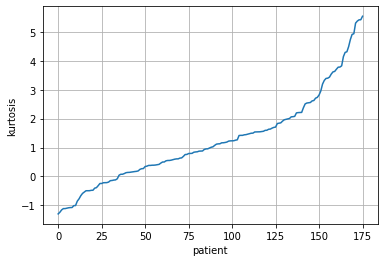

In [323]:
plt.plot(sorted(imagedf.kurt_val.values))
plt.xlabel('patient')
plt.ylabel('kurtosis')
plt.grid(True)

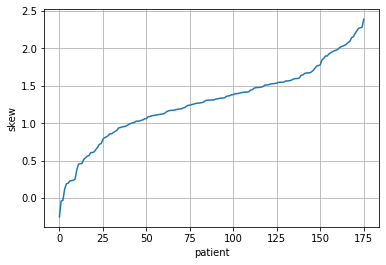

In [324]:
plt.plot(sorted(imagedf.skew_val.values))
plt.xlabel('patient')
plt.ylabel('skew')
plt.grid(True)

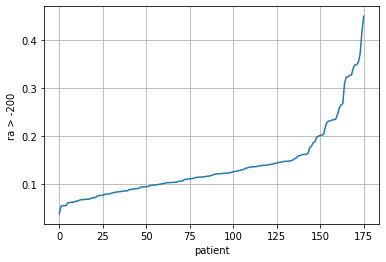

In [325]:
plt.plot(sorted(imagedf['ra_gt_-200'].values))
plt.xlabel('patient')
plt.ylabel('ra > -200')
plt.grid(True)

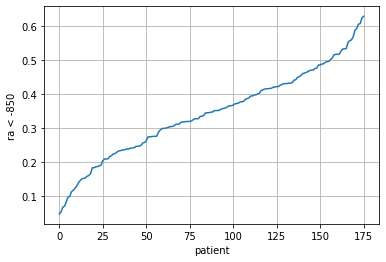

In [326]:
plt.plot(sorted(imagedf['ra_lt_-850'].values))
plt.xlabel('patient')
plt.ylabel('ra < -850')
plt.grid(True)

In [327]:
imagedf.columns

Index(['skew_val', 'kurt_val', 'ra_gt_0', 'ra_gt_-100', 'ra_gt_-200',
       'ra_gt_-300', 'ra_gt_-400', 'ra_lt_-750', 'ra_lt_-850', 'ra_lt_-950',
       ...
       'latent_1014', 'latent_1015', 'latent_1016', 'latent_1017',
       'latent_1018', 'latent_1019', 'latent_1020', 'latent_1021',
       'latent_1022', 'latent_1023'],
      dtype='object', length=1035)

In [392]:
data.shape

(2270, 10)

In [393]:
# append ct feat with table feat

new_data_list = []
#for n,row in data.iterrows():
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    patient_id = row['Patient']
    feat_file = os.path.join(feat_root,f'{patient_id}.csv')
    feat = pd.read_csv(feat_file)
    
    row = dict(row)
    feat = dict(feat.loc[0])
    row.update(feat)

    new_data_list.append(row)

data = pd.DataFrame(new_data_list)

100%|██████████| 2270/2270 [03:18<00:00, 11.42it/s]


In [395]:
print(data.shape)

(2270, 1045)


In [396]:
print(data.columns)

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'WHERE', 'Confidence', 'Patient_Week',
       ...
       'latent_1014', 'latent_1015', 'latent_1016', 'latent_1017',
       'latent_1018', 'latent_1019', 'latent_1020', 'latent_1021',
       'latent_1022', 'latent_1023'],
      dtype='object', length=1045)


In [397]:
print(data.shape)

(2270, 1045)


In [398]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [399]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']

base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')

base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [400]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [401]:
COLS = ['Sex','SmokingStatus']
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [402]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [404]:
feat_file = os.path.join(feat_root,f'{patient_id}.csv')
feat = pd.read_csv(feat_file)

In [405]:
FE += list(feat.columns)

In [406]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [407]:
keras.backend.clear_session()

C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)


def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

In [408]:
LR = 0.01
BETA_1 = 0.9
BETA_2 = 0.999
DECAY = 0.01
AMSGRAD = False

In [467]:
def make_model_without():
    z = L.Input((9,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="NN-Optimized")
    opt = tf.keras.optimizers.Adam(lr = LR, beta_1 = BETA_1, beta_2 = BETA_2, epsilon = None, decay = DECAY, amsgrad = AMSGRAD)
    model.compile(loss=mloss(0.8), optimizer = opt, metrics=[score])
    return model

def make_model_with():
    z = L.Input((9+1035,), name="Patient")
    input_shape = tf.shape(z)
    i = L.Lambda(lambda x: x[:,:9], output_shape=(input_shape[0],9))(z)
    l = L.Lambda(lambda x: x[:,9:], output_shape=(input_shape[0],1035))(z)
    
    l = L.Dense(512, activation="relu",)(l)
    l = L.Dense(256, activation="relu",)(l)
    l = L.Dense(512, activation="relu",)(l)
    l = L.Dropout(0.5)(l)
    l = L.Dense(256, activation="relu",)(l)
    l = L.Dense(128, activation="relu",)(l)
    l = L.Dense(256, activation="relu",)(l)
    l = L.Dropout(0.5)(l)
    l = L.Dense(32, activation="relu",)(l)
    l = L.Dense(16, activation="relu",)(l)
    l = L.Dense(32, activation="relu",)(l)
    l = L.Dropout(0.5)(l)
    
    x = tf.keras.layers.Concatenate()([i,l])
    x = L.Dense(100, activation="relu",)(x)
    x = L.Dropout(0.5)(x)
    x = L.Dense(100, activation="relu",)(x)
    x = L.Dropout(0.5)(x)
    p1 = L.Dense(3, activation="linear",)(x)
    x = L.Dropout(0.5)(x)
    p2 = L.Dense(3, activation="relu",)(x)
    x = L.Dropout(0.5)(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="NN-Optimized")
    opt = tf.keras.optimizers.Adam(lr = LR, decay=DECAY) #lr = LR, beta_1 = BETA_1, beta_2 = BETA_2, epsilon = None, decay = DECAY, amsgrad = AMSGRAD)
    model.compile(loss=mloss(0.8), optimizer = opt, metrics=[score])
    return model

In [419]:
y = tr['FVC'].values.astype(np.float64)
z = tr[FE].values
ze = sub[FE].values
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [421]:
z.dtype, y.dtype

(dtype('float64'), dtype('float64'))

In [422]:
z.shape,y.shape

((1535, 1044), (1535,))

In [423]:
net = make_model_without()
print(net.summary())
print(net.count_params())
history = net.fit(z[:,:9], y, batch_size=BATCH_SIZE, epochs=300, validation_split=0.2, verbose=0)


Model: "NN-Optimized"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
_______________________________________________________________________________________

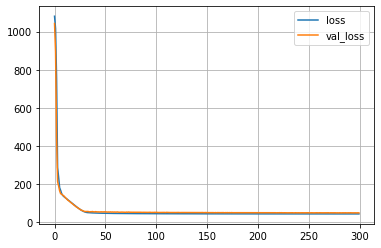

In [424]:
pred = net.predict(z[:,:9], batch_size=BATCH_SIZE, verbose=0)
pe = net.predict(ze[:,:9], batch_size=BATCH_SIZE, verbose=0)

lossdf = pd.DataFrame(history.history)
lossdf[['loss','val_loss']].plot()
plt.grid(True)

[6.575167179107666, 6.5773725509643555, 6.569210052490234, 6.575314521789551, 6.568846225738525]
[6.658761978149414, 6.661775588989258, 6.658498287200928, 6.661977767944336, 6.658295154571533]


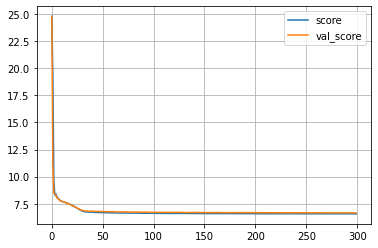

In [425]:
lossdf[['score','val_score']].plot()
plt.grid(True)
print(history.history['score'][-5:])
print(history.history['val_score'][-5:])

In [468]:
net = make_model_with()
print(net.summary())
print(net.count_params())

Model: "NN-Optimized"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 1044)]       0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1035)         0           Patient[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          530432      lambda_3[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 256)          131328      dense_13[0][0]                   
_______________________________________________________________________________________

In [469]:
print(z.shape,y.shape)

(1535, 1044) (1535,)


In [470]:
history = net.fit(z, y, batch_size=BATCH_SIZE, epochs=600, validation_split=0.2, verbose=0)

pred = net.predict(z, batch_size=BATCH_SIZE, verbose=0)
pe = net.predict(ze, batch_size=BATCH_SIZE, verbose=0)


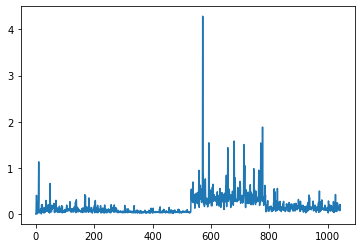

In [471]:
plt.plot(np.std(ze,axis=0))

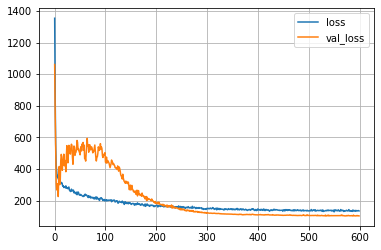

In [472]:
lossdf = pd.DataFrame(history.history)
lossdf[['loss','val_loss']].plot()
plt.grid(True)

[7.7587432861328125, 7.742753028869629, 7.768430233001709, 7.749945163726807, 7.758563041687012]
[7.611658096313477, 7.608894348144531, 7.596850872039795, 7.612172603607178, 7.595269680023193]


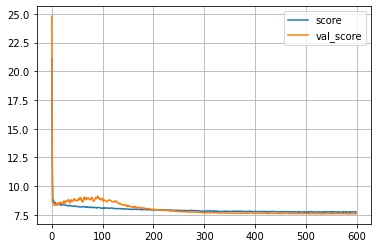

In [473]:
lossdf[['score','val_score']].plot()
plt.grid(True)
print(history.history['score'][-5:])
print(history.history['val_score'][-5:])

In [474]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

224.19188093253766 832.22833


(1535,)


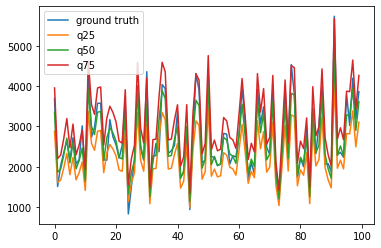

In [475]:
print(y.shape)
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

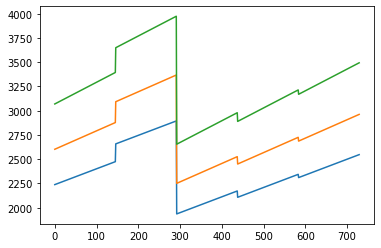

In [476]:
plt.plot(pe)

In [477]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

347.1455 832.22833 1575.4834 1.0


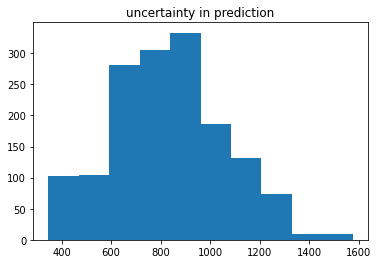

In [478]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [479]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent,FVC1,Confidence1
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,0,1,0,0,0.615385,0.3724,0.067901,0.332421,2332.959229,808.489380
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,0,1,0,0,0.615385,0.3724,0.074074,0.332421,2334.835449,809.132935
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,0,1,0,0,0.615385,0.3724,0.080247,0.332421,2336.711670,809.776733
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,0,1,0,0,0.615385,0.3724,0.086420,0.332421,2338.587402,810.420288
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,0,1,0,0,0.615385,0.3724,0.092593,0.332421,2340.463623,811.063843


In [480]:
sub.loc[:,'FVC1'] = pe[:, 1]
sub.loc[:,'Confidence1'] = pe[:, 2] - pe[:, 0]

In [481]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [482]:
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2602.337891,831.395508
1541,ID00419637202311204720264_-11,3020,100.0,2604.236328,832.002441
1542,ID00419637202311204720264_-10,3020,100.0,2606.134277,832.609375
1543,ID00419637202311204720264_-9,3020,100.0,2608.032471,833.216309
1544,ID00419637202311204720264_-8,3020,100.0,2609.930664,833.823486
1545,ID00419637202311204720264_-7,3020,100.0,2611.828613,834.430420
1546,ID00419637202311204720264_-6,3020,100.0,2613.727051,835.037354
1547,ID00419637202311204720264_-5,3020,100.0,2615.625000,835.644287
1548,ID00419637202311204720264_-4,3020,100.0,2617.523193,836.251221
1549,ID00419637202311204720264_-3,3020,100.0,2619.421387,836.858398


In [483]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']

if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [484]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2602.337891,831.395508,2602.337891,831.395508
1541,ID00419637202311204720264_-11,2604.236328,832.002441,2604.236328,832.002441
1542,ID00419637202311204720264_-10,2606.134277,832.609375,2606.134277,832.609375
1543,ID00419637202311204720264_-9,2608.032471,833.216309,2608.032471,833.216309
1544,ID00419637202311204720264_-8,2609.930664,833.823486,2609.930664,833.823486


In [485]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2754.010010,291.733704,2250.811279,2522.699097,2717.254150,2892.887207,3367.558350
Confidence,730.0,880.467834,94.509727,718.708374,805.567871,868.092896,924.669128,1079.376953
FVC1,730.0,2754.010010,291.733704,2250.811279,2522.699097,2717.254150,2892.887207,3367.558350
Confidence1,730.0,880.467834,94.509727,718.708374,805.567871,868.092896,924.669128,1079.376953


In [486]:
otest = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv')

for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [487]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [488]:
!ls -lh

total 68M
-rw-r--r-- 1 1000 1000  148 Sep 29 02:36 Dockerfile
-rw-r--r-- 1 1000 1000  317 Sep 29 03:16 README.md
drwxr-xr-x 2 1000 1000  12K Sep 30 16:00 cache
-rw-r--r-- 1 1000 1000 2.0M Oct  2 06:53 extract-ct-feature.ipynb
drwxr-xr-x 2 1000 1000 4.0K Sep 30 15:57 image
-rw-r--r-- 1 1000 1000 8.1M Oct  1 11:04 latent.h5
-rw-r--r-- 1 1000 1000 8.1M Sep 30 14:51 latent.h5BAK
-rw-r--r-- 1 1000 1000  24M Oct  1 11:04 lung_feat.h5
-rw-r--r-- 1 1000 1000  24M Sep 30 14:51 lung_feat.h5BAK
-rw-r--r-- 1 1000 1000  14K Oct  1 23:11 lung_list.json
drwxr-xr-x 2 1000 1000 4.0K Sep 30 15:57 mask
drwxr-xr-x 4 1000 1000 4.0K Sep 30 15:17 raw
-rw-r--r-- 1 1000 1000 2.1M Oct  1 23:37 raw_list.json
-rw-r--r-- 1 1000 1000  130 Sep 29 12:05 requirements.txt
drwxr-xr-x 2 1000 1000 4.0K Sep 29 10:35 static
-rw-r--r-- 1 1000 1000  35K Oct  2 07:11 submission.csv
drwxr-xr-x 2 1000 1000 4.0K Sep 29 04:19 temp
drwxr-xr-x 3 1000 1000 4.0K Oct  1 14:01 working


In [489]:
subm

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2602.337891,831.395508,2602.337891,831.395508
1541,ID00419637202311204720264_-11,2604.236328,832.002441,2604.236328,832.002441
1542,ID00419637202311204720264_-10,2606.134277,832.609375,2606.134277,832.609375
1543,ID00419637202311204720264_-9,2608.032471,833.216309,2608.032471,833.216309
1544,ID00419637202311204720264_-8,2609.930664,833.823486,2609.930664,833.823486
...,...,...,...,...,...
2265,ID00426637202313170790466_129,2954.102539,944.243896,2954.102539,944.243896
2266,ID00426637202313170790466_130,2956.000732,944.851318,2956.000732,944.851318
2267,ID00426637202313170790466_131,2957.898682,945.457764,2957.898682,945.457764
2268,ID00426637202313170790466_132,2959.796875,946.064941,2959.796875,946.064941
